# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [49]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0+cpu


# Preparing Training and Test Sets

In [50]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [106]:
%%writefile ChestXRayDataset.py

import os
import random
import torch
from PIL import Image

class ChestXRayDataset(torch.utils.data.Dataset):
        # image_dirs is a dictionary for 3 classes (covid, normal, viral)
        # transform object for data augmentation
        def __init__(self,image_dirs, transform):
            def get_images(class_name):
                # class name is either covid, normal or viral
                
                # get the images from image_dirs using class_name
                images = [image for image in os.listdir(image_dirs[class_name])]
                print("Total number of {} images: {}".format(class_name,len(images)))
                
                return images
            # dictionary to keep track of all the images
            self.images = {}
            
            # class names
            self.class_names = ['covid','normal','viral']
            
            for name in self.class_names:
                self.images[name] = get_images(name)
            
            # save the dirs and transform
            self.image_dirs = image_dirs
            self.transform = transform
        
        # returns the length of the dataset
        # i.e. number of images in all the three classes
        def __len__(self):
            return sum([ len(self.images[name]) for name in self.class_names])
        
        # given an index return the corresponding transformed image
        def __getitem__(self,index):
            
            # randomly choose any one of the 3 classes
            class_name = random.choice(self.class_names)
            
            # ensure that the index is in the bound of number of images in that class
            # used modulo reduction
            index = index % len(self.images[class_name])
            
            # get the image name
            image_name = self.images[class_name][index]
            
            # get the image path
            image_path = os.path.join(self.image_dirs[class_name],image_name)
            
            # Load the image, convert it to RGB
            image = Image.open(image_path).convert('RGB')
            
            # return transformed version of the image and the label (0,1,2)
            return self.transform(image), self.class_names.index(class_name)
            

Overwriting ChestXRayDataset.py


# Image Transformations

In [52]:
# two transformation objects which will be applied to training and test set
train_transform = torchvision.transforms.Compose([
    
    # resize the images to use them in pre-trained model
    torchvision.transforms.Resize(size=(224,224)),
    
    # data augmentation
    # flip horizontally
    torchvision.transforms.RandomHorizontalFlip(),
    
    # convert the image to tensor
    torchvision.transforms.ToTensor(),
    
    # normalize the data
    # using the mean, std same as resnet-18 model to take advantage of pretrained weights
    torchvision.transforms.Normalize(mean = [0.485,0.456,0.406],
                                     std = [0.229,0.224,0.225])
])

# no data augmentation in the test set
test_transform = torchvision.transforms.Compose([
    
    # resize the images to use them in pre-trained model
    torchvision.transforms.Resize(size=(224,224)),
    
    # convert the image to tensor
    torchvision.transforms.ToTensor(),
    
    # normalize the data
    # using the mean, std same as resnet-18 model to take advantage of pretrained weights
    torchvision.transforms.Normalize(mean = [0.485,0.456,0.406],
                                     std = [0.229,0.224,0.225])
])


# Prepare DataLoader

In [53]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}
train_dataset = ChestXRayDataset(train_dirs,train_transform)

Total number of covid images: 189
Total number of normal images: 1311
Total number of viral images: 1315


In [54]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs,test_transform)

Total number of covid images: 30
Total number of normal images: 30
Total number of viral images: 30


In [55]:
# creating data loader
batch_size = 6

# data loader for train set
dl_train = torch.utils.data.DataLoader(train_dataset,
                                       batch_size= batch_size,
                                       shuffle=True)
# data loader for test set
dl_test = torch.utils.data.DataLoader(test_dataset,
                                      batch_size= batch_size,
                                      shuffle=True)

# number of batches created
print("# training batches:",len(dl_train))
print("# test batches:", len(dl_test))

# training batches: 470
# test batches: 15


# Data Visualization

In [56]:
class_names = train_dataset.class_names  # covid, normal and viral

# function to display images
def disp(images,labels,preds):
    plt.figure(figsize=(8,4))
    
    # display a batch
    for i,image in enumerate(images):
        plt.subplot(1,batch_size,i+1,xticks = [],yticks = [])
        
        # convert tensor image to numpy array
        # the format for resnet-18 model is channel first
        image = image.numpy().transpose(1,2,0)
        
        # undo the normalize
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        
        # use x label to should ground truth
        # use y label to show prediction
        # green prediction - correct
        # red prediction - incorrect
        color = ""
        if preds[i] == labels[i]:
            color = 'green'
        else:
            color = 'red'
        
        plt.xlabel(str(class_names[int(labels[i].numpy())]))
        plt.ylabel(str(class_names[int(preds[i].numpy())]), color = color)
    
    plt.tight_layout()
    plt.show()

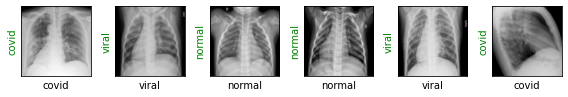

In [57]:
# training examples
images, labels = next(iter(dl_train))

# right now we do not have predictions 
# so we use the labels as ylabels
disp(images,labels,labels)

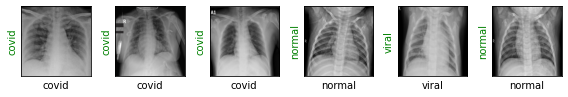

In [58]:
# testing examples
images, labels = next(iter(dl_test))
disp(images,labels,labels)

# Creating the Model

In [59]:
resnet18 = torchvision.models.resnet18(pretrained=True) # cnn

# change the number of output features for last layer  = 3
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

# define loss function
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(),lr = 3e-4)

In [132]:
def show_preds(model):
    model.eval()
    images, labels = next(iter(dl_test))
    outputs = model(images)
    print(images.numpy().shape)
    _, preds = torch.max(outputs,1)
    disp(images,labels,preds)

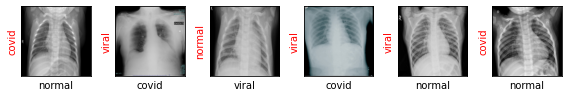

In [61]:
# see the prediction on pretrained weights
show_preds(resnet18)

# Training the Model

In [66]:
def train(epochs):
    print("Model training begins ...")
    for epoch in range(epochs):
        print("="*25)
        print("epoch: {}/{}".format(epoch+1,epochs))
        print("="*25)
        
        resnet18.train()
        train_loss = 0
        
        for step, (images,labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fun(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
            
            # evaluate the model at every 50th step
            if step % 50 == 0:
                print("Evaluation at step:",step)
                
                accuracy = 0 # validation accuracy
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images,labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fun(outputs,labels) 
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs,1)
                    accuracy += sum((preds == labels).numpy())
                    
                val_loss = val_loss/(val_step+1)
                accuracy = accuracy/len(test_dataset)
                print('Accuracy: {:.3f} Val Loss: {:.3f}'.format(accuracy,val_loss))
                show_preds(resnet18)
                
                resnet18.train()
                
                # if the accuracy is greater than 95% then we will return
                if accuracy >= 0.95:
                    print('Resonable accuracy achieved')
                    return
        train_loss = train_loss/(step+1)
        print('Train Loss: {:.3f}'.format(train_loss))

Model training begins ...
epoch: 1/1
Evaluation at step: 0
Accuracy: 0.722 Val Loss: 0.730


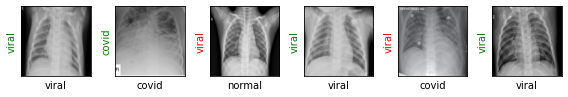

Evaluation at step: 50
Accuracy: 0.922 Val Loss: 0.165


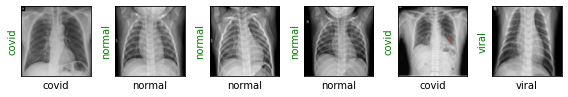

Evaluation at step: 100
Accuracy: 0.778 Val Loss: 0.570


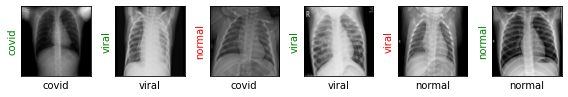

Evaluation at step: 150
Accuracy: 0.822 Val Loss: 0.402


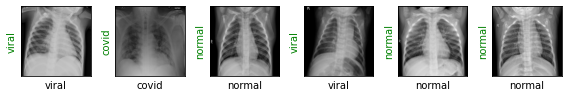

Evaluation at step: 200
Accuracy: 0.956 Val Loss: 0.141


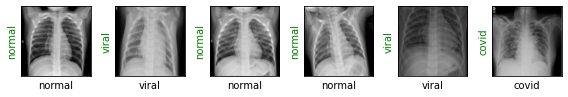

Resonable accuracy achieved


In [67]:
train(epochs = 1)

# Final Results

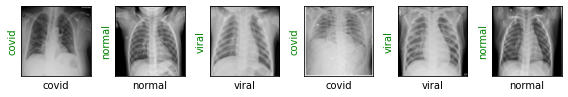

In [68]:
show_preds(resnet18)

## Save the model

In [69]:
torch.save(resnet18.state_dict(), 'covidRadiography.pth')

# ML server

In [143]:
%%writefile ml_server.py

# creating a basic flask server

import json
import torch
import torchvision
import random
import numpy as np
from ChestXRayDataset import ChestXRayDataset

from flask import Flask, request

app = Flask(__name__)

# create model
resnet18model = torchvision.models.resnet18(pretrained=False)

# change the number of output features for last layer  = 3
resnet18model.fc = torch.nn.Linear(in_features=512, out_features=3)

# load the model
resnet18model.load_state_dict(torch.load('covidRadiography.pth'))

dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

transformation = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)), # resize the images to use them in pre-trained model
    torchvision.transforms.ToTensor(), # convert the image to tensor
    # normalize the data
    # using the mean, std same as resnet-18 model to take advantage of pretrained weights
    torchvision.transforms.Normalize(mean = [0.485,0.456,0.406],
                                     std = [0.229,0.224,0.225])
])

batch_size = 6
dataset = ChestXRayDataset(dirs,transformation)
dl = torch.utils.data.DataLoader(dataset,
                                 batch_size= batch_size,
                                 shuffle=True)

def get_prediction():
    resnet18model.eval()
    images, labels = next(iter(dl))
    outputs = resnet18model(images)
    _, preds = torch.max(outputs,1)
    return images.numpy().tolist(),labels.numpy().tolist(),preds.numpy().tolist()


@app.route('/', methods = ['GET','POST'])

def index():
    if request.method == 'POST':
        images,labels,preds = get_prediction()
        
        return json.dumps({
            'predictions': preds,
            'images': images,
            'labels': labels
        })
    return "Welcome to ML server"

if __name__ == '__main__':
    app.run()

Overwriting ml_server.py


# Streamlit web application

In [161]:
%%writefile app.py

# import streamlit as st
# from PIL import Image
# st.set_option('deprecation.showfileUploaderEncoding', False)

# st.title("Upload + Classification Example")
# file_up = st.file_uploader("Upload an image", type="png")

# if file_up is not None:
#     image = Image.open(file_up)
#     st.image(image, caption='Uploaded Image.', use_column_width=True)
#     st.write("addy")

import streamlit as st
import json
import random
import requests
import matplotlib.pyplot as plt
import numpy as np

URI = 'http://127.0.0.1:5000/'
class_names = ['covid','normal','viral']
batch_size = 6

st.title("Detecting COVID-19 with Chest X-Ray using PyTorch")
st.write("The label on the x-axis is the ground truth")
st.write("The label on the y-axies is the prediction. Green color means that the prediction matches the ground truth otherwise the color is red.")

if st.button('Get random predictions'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('predictions')
    images = response.get('images')
    labels = response.get('labels')
    plt.figure(figsize=(12,8))

    # display a batch
    for i,image in enumerate(images):
        plt.subplot(1,batch_size,i+1,xticks = [],yticks = [])

        # convert tensor image to numpy array
        # the format for resnet-18 model is channel first
        image = np.array(image).transpose(1,2,0)

        # undo the normalize
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)

        # use x label to should ground truth
        # use y label to show prediction
        # green prediction - correct
        # red prediction - incorrect
        color = ""
        if preds[i] == labels[i]:
            color = 'green'
        else:
            color = 'red'

        plt.xlabel(str(class_names[int(labels[i])]))
        plt.ylabel(str(class_names[int(preds[i])]), color = color)
    st.pyplot()

Overwriting app.py
